In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os 
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Load the dataset
To make sure equally distributed data in both train and test set we create a column 'income_cat'

In [2]:
df = pd.read_csv('housing.csv')
df['income_cat'] = pd.cut(df['median_income'],bins=[0,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


## Split The Data into Training and Testing

In [ ]:
for train_indices , test_indices in split.split(df,df['income_cat']):
    train_model = df.loc[train_indices]
    test_model = df.loc[test_indices]

Text(0, 0.5, 'Values')

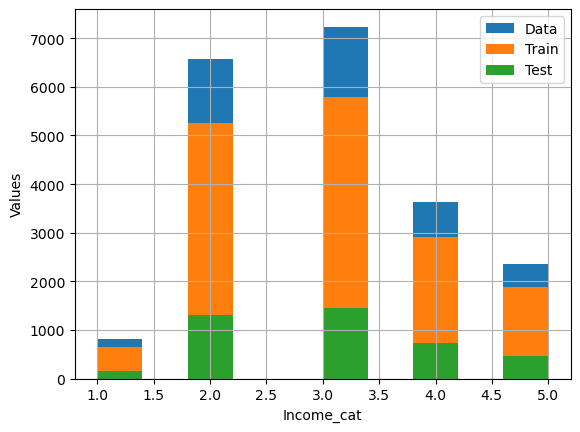

In [ ]:
df['income_cat'].hist(label='Data')
train_model['income_cat'].hist(label='Train')
test_model['income_cat'].hist(label='Test')
plt.legend()
plt.xlabel('Income_cat')
plt.ylabel('Values')
## This shows that all the data are present in both train and test sets. 

## Visualization

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

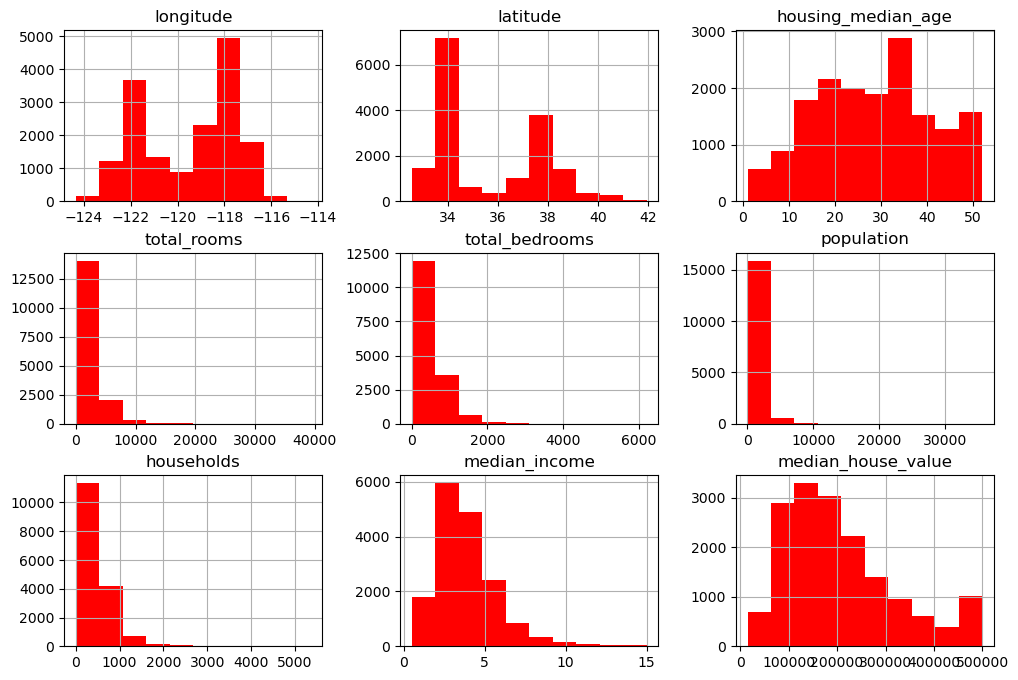

In [5]:
housing = train_model.drop('income_cat',axis=1)
housing.hist(figsize=(12,8),color='red')

<Axes: xlabel='latitude', ylabel='longitude'>

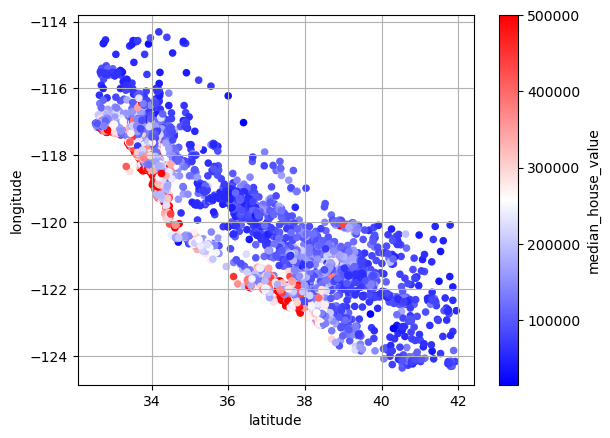

In [6]:
housing.plot(kind='scatter',x='latitude',y='longitude',grid=True,cmap='bwr',c='median_house_value')
## This Graph shows that at low latitude the price was high

<Axes: >

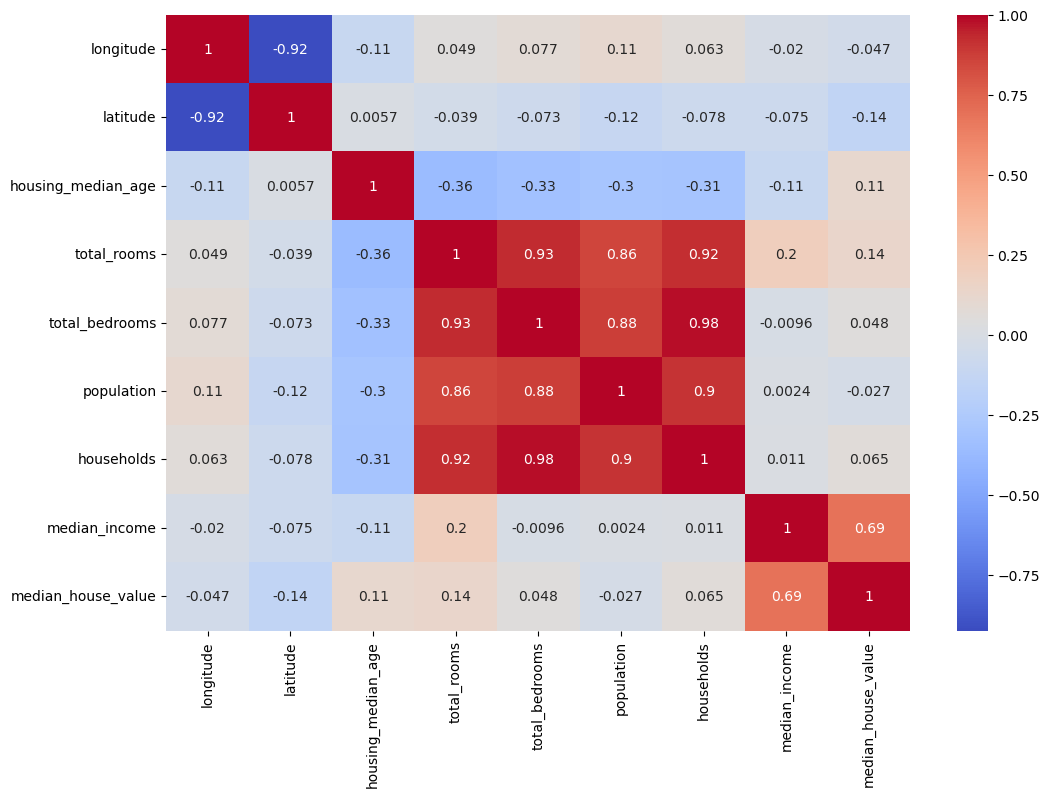

In [7]:
housing_num = housing.select_dtypes(include=[np.number])
plt.figure(figsize=(12,8))
sns.heatmap(housing_num.corr(),cmap='coolwarm',annot=True)
# This heatmap helps to visualize the relation

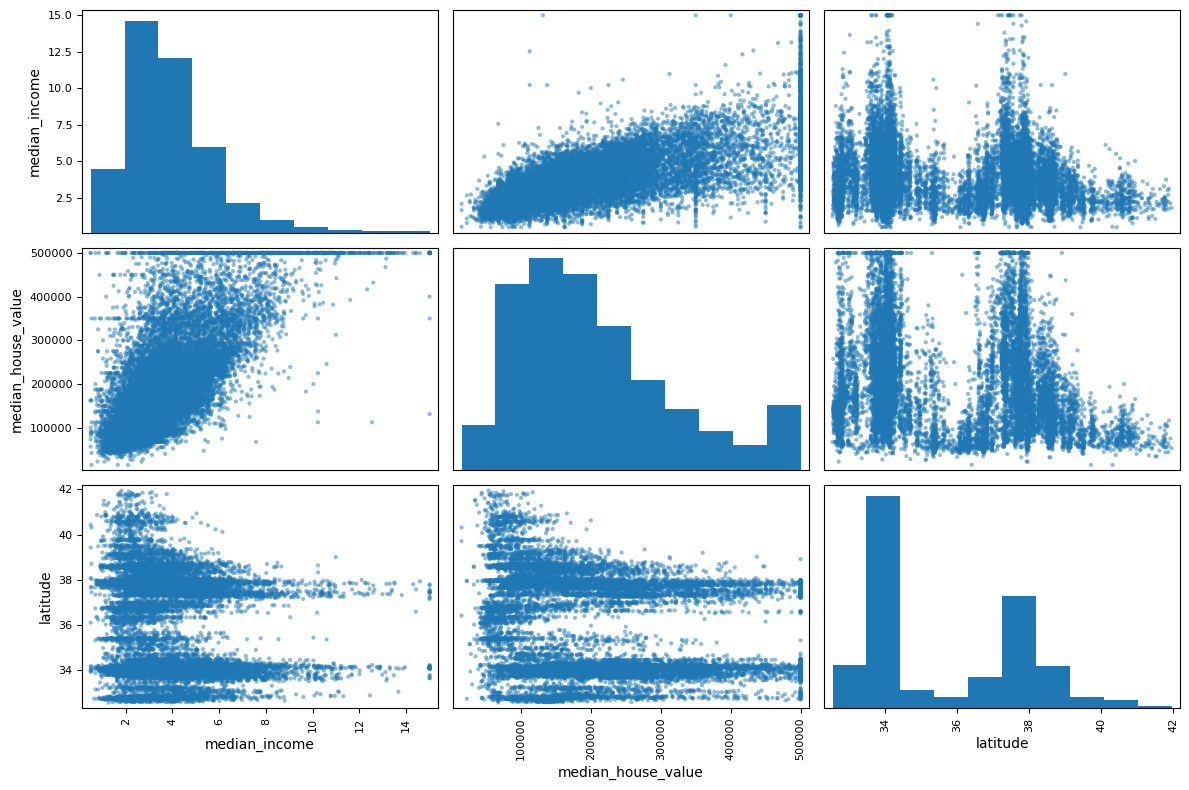

In [8]:
# for more understanding
attributes  = ['median_income','median_house_value','latitude']
scatter_matrix(housing_num[attributes],figsize=(12,8))
plt.tight_layout()
# These graphs shows realtion with each other

## Handle missing value

In [9]:
housing_features = housing.drop('median_house_value',axis=1)
housing_labels = train_model['median_house_value']
housing_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [10]:
# Using simpleImputer change the missing value by median
housing_num_new = housing_features.drop('ocean_proximity',axis=1)
impute = SimpleImputer(strategy='median')
new_impute = impute.fit_transform(housing_num_new)
new_housing = pd.DataFrame(new_impute,columns=housing_num_new.columns,index=housing_num_new.index)
new_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handle Categorical value

In [11]:
housing_cat = housing[['ocean_proximity']]
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [12]:
set(housing_cat['ocean_proximity'])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [13]:
encode = OneHotEncoder()
new_encode = encode.fit_transform(housing_cat)
housing_cat_num = pd.DataFrame(new_encode.toarray(),columns=['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],index=housing_cat.index)
housing_cat_num

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,0.0,1.0,0.0,0.0,0.0
15502,0.0,0.0,0.0,0.0,1.0
2908,0.0,1.0,0.0,0.0,0.0
14053,0.0,0.0,0.0,0.0,1.0
20496,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
15174,1.0,0.0,0.0,0.0,0.0
12661,0.0,1.0,0.0,0.0,0.0
19263,1.0,0.0,0.0,0.0,0.0
19140,1.0,0.0,0.0,0.0,0.0


In [14]:
housing_prepared = pd.concat([new_housing,housing_cat_num],axis=1)
housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,0.0,1.0,0.0,0.0,0.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,0.0,0.0,0.0,0.0,1.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,0.0,1.0,0.0,0.0,0.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,0.0,0.0,0.0,0.0,1.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1.0,0.0,0.0,0.0,0.0


## Feature Scalling

In [15]:
scale = StandardScaler()
new_scale = scale.fit_transform(housing_prepared)
housing_final = pd.DataFrame(new_scale,columns=housing_prepared.columns,index=housing_prepared.index)
housing_final

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,-0.887683,-0.68391,-0.011006,-0.354889,2.602693
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.887683,-0.68391,-0.011006,-0.354889,2.602693
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,1.126529,-0.68391,-0.011006,-0.354889,-0.384217


## Select the Rigth Model with lowest RMSE value

In [16]:
# 1.LinearRegression
lnr_reg = LinearRegression()
lnr_crs = -cross_val_score(lnr_reg,housing_final,housing_labels,scoring='neg_root_mean_squared_error',cv=10)
print(f'RMSE with Linear regression with Cross Validation is: {lnr_crs.mean()}')
#2. DecisionTreeRegressor
dec_reg = DecisionTreeRegressor()
dec_crs = -cross_val_score(dec_reg,housing_final,housing_labels,scoring='neg_root_mean_squared_error',cv=10)
print(f'\nRMSE with DecisionTreeRegressor with Cross Validation is: {dec_crs.mean()}')
#3. RandomForestRegressor
rnd_frst = RandomForestRegressor()
rnd_crs = -cross_val_score(rnd_frst,housing_final,housing_labels,scoring='neg_root_mean_squared_error',cv=10)
print(f'\nRMSE with RandomForestRegressor with Cross Validation is: {rnd_crs.mean()}')

RMSE with Linear regression with Cross Validation is: 69204.32275494763

RMSE with DecisionTreeRegressor with Cross Validation is: 68876.75935003054

RMSE with RandomForestRegressor with Cross Validation is: 49447.27363270557


## Full and final model with pipelines and RandomForestRegressor

In [ ]:
MODEL_FILE = 'model.pkl'
PIPELINE_FILE = 'pipeline.pkl'

def build_pipeline(num_attri,cat_attri):
    num_pipeline = Pipeline([
        ('impute',SimpleImputer(strategy='median')),
        ('scale',StandardScaler())
])
    cat_pipeline = Pipeline([
    ('encode',OneHotEncoder(handle_unknown='ignore'))
])
    final_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attri),
    ('cat',cat_pipeline,cat_attri)
])
    return final_pipeline
if not os.path.exists(MODEL_FILE):
    df = pd.read_csv('housing.csv')
    df['income_cat'] = pd.cut(df['median_income'],bins=[0,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])
    split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
    for train_indices , test_indices in split.split(df,df['income_cat']):
        train_model = df.loc[train_indices].drop('income_cat',axis=1)
        test_model = df.loc[test_indices].drop('income_cat',axis=1)
    test_model.to_csv('test.csv')
    housing = train_model.drop('median_house_value',axis=1)
    housing_labels = train_model['median_house_value']
    num_attri = housing.drop('ocean_proximity',axis=1).columns.tolist()
    cat_attri = ['ocean_proximity']
    
    pipeline = build_pipeline(num_attri,cat_attri)
    housing_prepared = pipeline.fit_transform(housing)

    model = RandomForestRegressor()
    model.fit(housing_prepared,housing_labels)

    joblib.dump(model,MODEL_FILE)
    joblib.dump(pipeline,PIPELINE_FILE)

    print('Good_to_Go')
else:
    model = joblib.load(MODEL_FILE)
    pipeline = joblib.load(PIPELINE_FILE)
    
    input_data = pd.read_csv('test.csv')
    transform_data = pipeline.transform(input_data)
    predicttion = model.predict(transform_data)
    input_data['predict_value'] = predicttion
    input_data.to_csv('predicted_data.csv',index=False)
    print('Done!!!')
    

Done!!!
